In [1]:
import random
from collections import deque
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector
from scipy.stats import poisson, norm

import random
import time

In [2]:
# This is global parameter for the step size in the simulation
# Latencies are adjusted in reference to this step size, but 
# step size should be less than (and probably a LCD) of agent delays
# The unit is seconds, so mss = 0.005 --> 5 ms

model_step_size = 0.005
#model_step_size = 0.001

In [3]:
# Define the player class
class Player(Agent):
    def __init__(self, unique_id, model, pm, delay, probability, agent_type):
        super().__init__(unique_id, model)
        self.pm = pm  # Profit margin
        self.delay = delay
        self.probability = probability
        self.bid = 0
        self.private_signal_value = 0
        self.aggregated_signal = 0
        self.bid_queue = deque(maxlen=(self.delay + self.model.global_delay))
        self.agent_type = agent_type

    def update_aggregated_signal(self):
        self.aggregated_signal = self.model.public_signal_value + self.private_signal_value

    def step(self):
        self.update_aggregated_signal()
        # Logic for making a bid, specific to each strategy subclass

    def advance(self):
        if len(self.bid_queue) == self.delay + self.model.global_delay:
            self.model.current_bids.append(self.bid_queue.popleft())
            self.model.bid_agents.append(self.unique_id)

In [4]:
# This builder mimics a local block builder. Taking no profit, but only having access to the public mempool
class PlayerMempoolBuilder(Player):
    def step(self):
        super().step()

        if self.model.public_signal_value > 0:
            self.bid = self.model.public_signal_value
        
        self.bid_queue.append((self.bid, self.aggregated_signal))

In [5]:
# kept as a reference on how to add biding delays later
class PlayerWithLastMinuteStrategy(Player):
    def __init__(self, unique_id, model, pm, delay, probability, time_estimate, time_reveal_epsilon):
        super().__init__(unique_id, model, pm, delay, probability, agent_type='Last Minute')
        self.time_estimate = time_estimate
        self.time_reveal_epsilon = time_reveal_epsilon

    def step(self):
        super().step()
        time_reveal = self.time_estimate - self.time_reveal_epsilon - self.model.global_delay - self.delay
        if self.model.schedule.time >= time_reveal:
            if self.aggregated_signal > self.pm:
                self.bid = self.aggregated_signal - self.pm
        self.bid_queue.append((self.bid, self.aggregated_signal))

In [6]:
# I switched this to percentage outbidding
class PlayerWithAdaptiveStrategy(Player):
    def __init__(self, unique_id, model, pm, delay, probability, time_estimate, time_reveal_epsilon, agent_type):
        super().__init__(unique_id, model, pm, delay, probability, agent_type)
        self.time_estimate = time_estimate
        self.time_reveal_epsilon = time_reveal_epsilon
    
    def step(self):
        super().step()
        self.pm = 0 # this is a red-herring honestly 

        time_reveal = self.time_estimate - self.time_reveal_epsilon - self.model.global_delay - self.delay
        if self.model.schedule.time < time_reveal:
            self.bid = 0
            self.bid_queue.append((self.bid, self.aggregated_signal))
            return

        if self.aggregated_signal > self.pm and len(self.model.max_bids) > 0:
            
            # Look back through the bid data and find the highest leading bid by a competitor
            tmp = self.model.datacollector.get_model_vars_dataframe()
            best_competitor_bid = 0
            for xx in reversed(range(0, len(tmp))):
                try:
                    own_bid = tmp['Current Bids'][xx][self.unique_id][0]
                    best_competitor_bid = max([x for i, (x, _) in enumerate(tmp['Current Bids'][xx]) if i != self.unique_id])
                    if best_competitor_bid >= own_bid:
                        break
                except IndexError: # no bids
                    break

            # Builders now outbid competitors by a fixed percent of profit (currently 10%)
            if self.aggregated_signal - self.pm > best_competitor_bid:
                self.bid = (self.aggregated_signal - best_competitor_bid) * 0.1 + best_competitor_bid
            elif self.aggregated_signal <= best_competitor_bid: # fallback bid to just your top block value
                self.bid = self.aggregated_signal


        self.bid_queue.append((self.bid, self.aggregated_signal))

In [7]:
def get_current_bids(model):
    return model.show_current_bids

def get_bid_agents(model):
    return model.show_bid_agents

def get_public_signal(model):
    return model.public_signal_value

def get_private_signal_max(model):
    return model.private_signal_max

def get_aggregated_signal_max(model):
    return model.aggregated_signal_max

In [8]:
# Global map of all agent types, so we know who's who
agent_map = {}

class Auction(Model):
    def __init__(self, M, A, L, H, rate_public_mean, rate_public_sd, rate_private_mean, rate_private_sd,
                 T_mean, T_sd, delay,):
        super().__init__()
        self.num_agents = {
            'Mempool': M, 
            'Adaptive': A, 
            'LowLatency': L, 
            'HighLatency': H, 
        }
        self.global_delay = 1
        self.T = norm.rvs(loc=T_mean, scale=T_sd)
        self.schedule = SimultaneousActivation(self)
        self.setup_agents()
        self.setup_signals(rate_public_mean, rate_public_sd, rate_private_mean, rate_private_sd)
        self.setup_bids()
        self.setup_winner()
        self.datacollector = DataCollector(
            model_reporters={
                "Current Bids" : get_current_bids,
                "Agents" : get_bid_agents,
                "Public Signal" : get_public_signal,
                "Private Signal Max" : get_private_signal_max,
                "Aggregated Signal Max" : get_aggregated_signal_max,
            },
            agent_reporters={"Bid" : "bid",
                             "Probability" : "probability",
                             }
        )

    def setup_agents(self):
        # Initialize agents with their strategies
        agent_id = 0
        for strategy, count in self.num_agents.items():
            for _ in range(count):
                pm = norm.rvs(loc=0.00659, scale=0.0001)
                delay = 1
                #probability = np.random.uniform(0.8, 1.0) # probability of getting a piece of orderflow
                probability = 1  # probability of getting a piece of orderflow
                if strategy == 'Mempool':
                    delay = int(5 / (1000 * model_step_size)) # local builder, therefore latency --> 0
                    pm = 0
                    agent = PlayerMempoolBuilder(agent_id, self, pm, delay, probability, agent_type='Mempool')
                    agent_map[agent_id] = 'Mempool Builder:' + str(agent_id)
                elif strategy == 'LowLatency':
                    #delay = int(5 / (1000 * model_step_size))
                    delay = int(35 / (1000 * model_step_size))
                    time_estimate = 10000 / (1000 * model_step_size) # 10s into the 12+t auction
                    time_reveal_epsilon = 0
                    agent = PlayerWithAdaptiveStrategy(agent_id, self, pm, delay, probability, time_estimate, time_reveal_epsilon, agent_type='LowLatency')
                    agent_map[agent_id] = 'Colocated Builder:' + str(agent_id)
                elif strategy == 'HighLatency':
                    #delay = int(50 / (1000 * model_step_size))
                    delay = int(125 / (1000 * model_step_size))
                    time_estimate = 6000 / (1000 * model_step_size) # 6s into the 12+t auction
                    time_reveal_epsilon = 0
                    agent = PlayerWithAdaptiveStrategy(agent_id, self, pm, delay, probability, time_estimate, time_reveal_epsilon, agent_type='HighLatency')
                    agent_map[agent_id] = 'Transatlantic Builder:' + str(agent_id)
                self.schedule.add(agent)
                agent_id += 1

    def setup_signals(self, rate_public_mean, rate_public_sd, rate_private_mean, rate_private_sd):
        # Initialize signal parameters
        self.public_signal = 0
        self.public_signal_value = 0
        self.private_signal = 0
        self.private_signal_max = 0
        self.aggregated_signal_max = 0
        self.public_lambda = norm.rvs(loc=rate_public_mean, scale=rate_public_sd)
        self.private_lambda = norm.rvs(loc=rate_private_mean, scale=rate_private_sd)

    def setup_bids(self):
        self.max_bids = []
        self.current_bids = []
        self.bid_agents = []
        self.winning_agents = []
        self.show_current_bids = []
        self.show_bid_agents = []

    def setup_winner(self):
        self.winner_profit = 0
        self.winner_trueprofit = 0
        self.winner_aggregated_signal = 0
        self.winner_probability = 0
        self.auction_efficiency = 0

    def step(self):
        # Update public signal
        new_public_signal = poisson.rvs(mu=self.public_lambda)
        self.public_signal += new_public_signal

        for _ in range(new_public_signal) :
            signal_value = np.random.lognormal(mean=-11.66306, sigma=3.05450)
            # Add the value of the current public signal to the total value
            self.public_signal_value += signal_value

        # Update private signal
        new_private_signal = poisson.rvs(mu=self.private_lambda)
        self.private_signal += new_private_signal

        for _ in range(new_private_signal) :
            private_signal_value = np.random.lognormal(mean=-8.41975, sigma=1.95231)
            self.private_signal_max += private_signal_value
            for agent in self.schedule.agents :
                if random.random() < agent.probability :
                    agent.private_signal_value += private_signal_value

        self.aggregated_signal_max = self.public_signal_value + self.private_signal_max

        self.schedule.step()

        # select the winner of the step
        if self.current_bids :
            max_bid_value = max(bid for bid, _ in self.current_bids)
            # Get all bids that are equal to the maximum bid value
            max_bids = [(bid, agent_id) for bid, agent_id in zip(self.current_bids, self.bid_agents) if
                        bid[0] == max_bid_value]
            # Randomly select one of the maximum bids
            selected_bid, winner_id = random.choice(max_bids)
            self.max_bids.append(selected_bid[0])
            self.winning_agents.append(winner_id)
            self.winner_profit = selected_bid[1]-selected_bid[0]
            if self.aggregated_signal_max == 0:
                self.auction_efficiency = 0
            else:
                self.auction_efficiency = selected_bid[0]/self.aggregated_signal_max

            for agent in self.schedule.agents:
                if agent.unique_id == winner_id:
                    self.winner_aggregated_signal = selected_bid[1]
                    self.winner_probability = agent.probability


        self.show_current_bids = self.current_bids.copy()
        self.show_bid_agents = self.bid_agents.copy()

        self.current_bids.clear()
        self.bid_agents.clear()

        # Collect data at the end of the step
        self.datacollector.collect(self)

In [9]:
# Function to run the model and collect data
model = Auction(
    M=1, A=0, L=1, H=1, 
    rate_public_mean=0.02, 
    rate_public_sd=0.01, 
    rate_private_mean=0.01, 
    rate_private_sd=0.005, 
    T_mean=13.5, 
    T_sd=1, 
    delay = 50
)
for i in range(int(model.T * (1/model_step_size))): # the units for reveal is 12.5 * xx # 200 ---> 5ms steps
    model.step()

# Data Collection
model_data = model.datacollector.get_model_vars_dataframe()
agent_data = model.datacollector.get_agent_vars_dataframe()

In [10]:
# Print the simulation details
print(f"Public signal number: {model.public_signal}")
print(f"Public signal value: {model.public_signal_value}")
print(f"Private signal number: {model.private_signal}")
print(f"Auction time (seconds): {model.T}")
print(f"Auction time steps: {model.schedule.time}")
print("\n")
print(agent_data.loc[i, 'Probability'])
#print("\n")
#print(f"Winning Bid of Each Step: {model.max_bids}")
#print(f"Winning Agent of Each Step: {model.winning_agents}")

Public signal number: 57
Public signal value: 0.008962077105607414
Private signal number: 25
Auction time (seconds): 13.5890747405451
Auction time steps: 2717


AgentID
0    1
1    1
2    1
Name: Probability, dtype: int64


In [11]:
current_agents = model_data["Agents"].iloc[i]

/var/folders/ky/7gpzcj_s62zgx2_p11m9_qfc0000gp/T/ipykernel_70815/195646554.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([int(x * model_step_size * 1000) for x in plt.gca().get_xticks()])


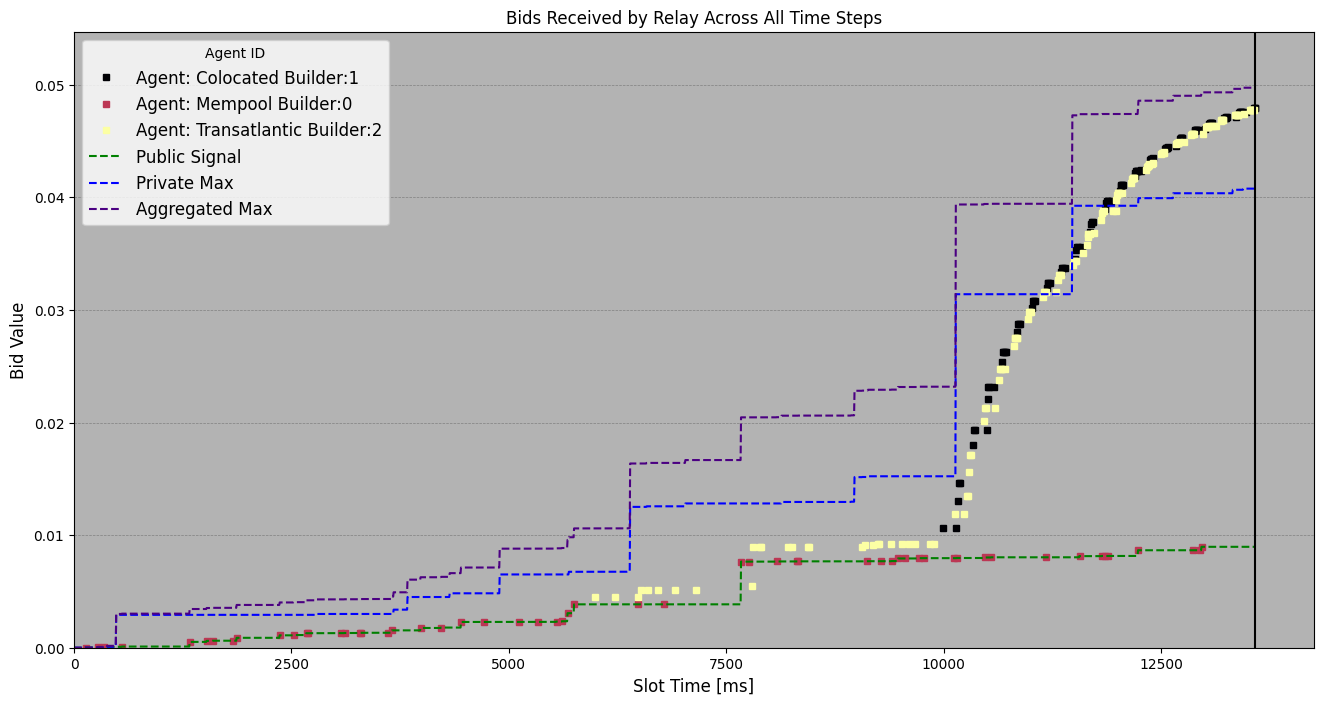

In [12]:
# This is just plotting code.
dfs = []
for i in range(len(model_data)):
    current_bids = model_data["Current Bids"].iloc[i]
    current_agents = model_data["Agents"].iloc[i]

    if current_bids:
        bids, aggregated_signals = zip(*current_bids)
    else:
        bids, aggregated_signals = [], []

    for agent, bid, signal in zip(current_agents, bids, aggregated_signals):
        dfs.append(pd.DataFrame({
            "Time Step": [i],
            "Agent ID": [f"Agent: {agent_map[agent]}"],
            "Bid": [bid],
            "Signal": [signal]
        }))

# Concatenate all DataFrames
all_bids = pd.concat(dfs)
public_signals = model_data["Public Signal"]
private_signal_max = model_data["Private Signal Max"]
aggregated_signal_max = model_data["Aggregated Signal Max"]
# Pivot the DataFrame to have time steps as index and agents' bids as columns
pivot_bids = all_bids.pivot(index="Time Step", columns="Agent ID", values="Bid")

# Plotting
plt.figure(figsize=(16, 8))
plt.gca().set_prop_cycle('color', plt.cm.inferno(np.linspace(0, 1, len(pivot_bids.columns))))

fontsize = 12
for column in pivot_bids.columns:
    # only print higher new bids
    tmp = pd.DataFrame(pivot_bids[column])
    tmp = tmp[tmp[column].diff() > 0]
    plt.plot(tmp.index, tmp[column], 's', label=column, ms = 4)

# Adding other signals to the plot
plt.plot(public_signals.index, public_signals, label='Public Signal', linewidth=1.5, color='green', ls = '--')
plt.plot(private_signal_max.index, private_signal_max, label='Private Max', linewidth=1.5, color='blue', ls = '--')
plt.plot(aggregated_signal_max.index, aggregated_signal_max, label='Aggregated Max', linewidth=1.5, color='indigo', ls = '--')

# Rest of the plotting code remains the same
plt.xlabel('Slot Time [ms]', fontsize=fontsize)
plt.ylabel('Bid Value', fontsize=fontsize)
plt.legend(title='Agent ID', fontsize=12)
plt.title('Bids Received by Relay Across All Time Steps', fontsize=fontsize)
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')


plt.axvline(max(public_signals.index), color='k')
plt.xlim([0, max(public_signals.index) * 1.05])
plt.gca().set_xticklabels([int(x * model_step_size * 1000) for x in plt.gca().get_xticks()])
plt.ylim([0, max(aggregated_signal_max)*1.1])

plt.gca().set_facecolor([0.7]*3)

plt.savefig(f'./resources/simulation-t-{int(time.time())}.png') # save with a random filename
plt.show()

In [13]:
model_data['slot_time'] = model_data.index * model_step_size

In [14]:
# Need to adapt this to work with more than just two agents (high/low latency)
low_lat = 0
high_lat = 0
for xx in range(len(model_data)):
    if model_data['slot_time'][xx] < 10:
        continue

    bids = model_data['Current Bids'][xx]
    if bids[1][0] > bids[2][0]:
        low_lat += 1
    else:
        high_lat += 1


print("Colocated Leaders:", low_lat)
print("Transatlantic Leaders:", high_lat)
print("Colocated Odds:", low_lat/(low_lat + high_lat))


Colocated Leaders: 551
Transatlantic Leaders: 166
Colocated Odds: 0.7684797768479776
